## Gemini API

In [ ]:
#importing the required libraries
import os
import google.generativeai as genai
import dotenv

/Users/sriujjwalreddyb/SceneGraphVLM/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Paris



### Loading the GEMINI MODEL

2025-01-30 13:27:04 - INFO - Starting program execution...
2025-01-30 13:27:04 - INFO - Starting environment setup...
2025-01-30 13:27:04 - INFO - Configuring Gemini API...
2025-01-30 13:27:04 - INFO - Environment setup completed successfully
2025-01-30 13:27:04 - INFO - Starting visualization for image ID: 1
2025-01-30 13:27:04 - INFO - Starting image download for ID: 1
2025-01-30 13:27:04 - INFO - Successfully loaded image data with 108077 entries
2025-01-30 13:27:04 - INFO - Downloading image from URL: https://cs.stanford.edu/people/rak248/VG_100K_2/1.jpg
2025-01-30 13:27:04 - INFO - Successfully downloaded image: (800, 600)
2025-01-30 13:27:04 - INFO - Starting scene graph generation
2025-01-30 13:27:04 - INFO - Initializing Gemini model...
2025-01-30 13:27:04 - INFO - Sending request to Gemini API...
2025-01-30 13:27:08 - INFO - Successfully parsed scene graph with 8 objects
2025-01-30 13:27:08 - INFO - Graph created with 8 nodes and 6 edges
2025-01-30 13:27:08 - INFO - Creating v

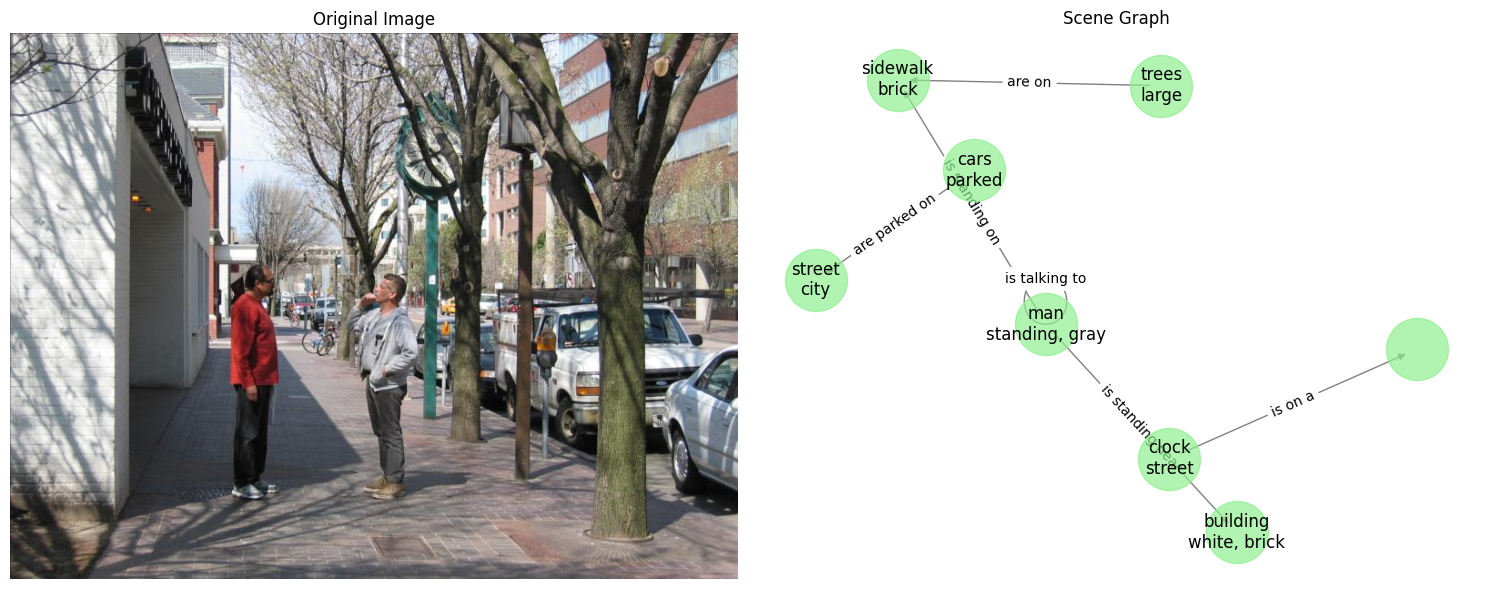

2025-01-30 13:27:10 - INFO - Printing statistics...
2025-01-30 13:27:10 - INFO - Visualization completed successfully
2025-01-30 13:27:10 - INFO - Program completed successfully



Scene Graph Statistics:
Number of objects: 8
Number of relationships: 6

Objects and their attributes:
- man: red, standing
- man: standing, gray
- sidewalk: brick
- building: white, brick
- trees: large
- street: city
- cars: parked
- clock: street

Relationships:
- man is standing on sidewalk
- man is standing near building
- trees are on sidewalk
- cars are parked on street
- clock is on a pole
- man is talking to man


In [5]:
import os
import google.generativeai as genai
import dotenv
import networkx as nx
import matplotlib.pyplot as plt
from PIL import Image
import json
import requests
import base64
from io import BytesIO
import logging
import traceback

# Configure detailed logging
logging.basicConfig(
    level=logging.DEBUG,  # Set to DEBUG for maximum verbosity
    format='%(asctime)s - %(levelname)s - [%(filename)s:%(lineno)d] - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)
logger = logging.getLogger(__name__)

def setup_environment():
    """Setup environment and API configurations"""
    try:
        logger.info("Starting environment setup...")
        
        # Load environment variables
        dotenv.load_dotenv()
        api_key = os.getenv("GEMINI_API_KEY")
        if not api_key:
            logger.error("GEMINI_API_KEY not found in environment variables")
            raise ValueError("Missing GEMINI_API_KEY")
            
        # Configure Gemini API
        logger.info("Configuring Gemini API...")
        genai.configure(api_key=api_key)
        logger.info("Environment setup completed successfully")
        
    except Exception as e:
        logger.error(f"Environment setup failed: {str(e)}")
        logger.debug(f"Traceback: {traceback.format_exc()}")
        raise

def download_vg_image(image_id):
    """Download an image from Visual Genome"""
    logger.info(f"Starting image download for ID: {image_id}")
    
    try:
        # Check if json directory exists
        if not os.path.exists('json'):
            logger.error("json directory not found")
            raise FileNotFoundError("json directory not found")
        
        # Load image data
        logger.debug("Reading image_data.json...")
        try:
            with open('json/image_data.json', 'r') as f:
                image_data = json.load(f)
                logger.info(f"Successfully loaded image data with {len(image_data)} entries")
        except FileNotFoundError:
            logger.error("image_data.json not found in json directory")
            raise
        except json.JSONDecodeError as e:
            logger.error(f"Failed to parse image_data.json: {str(e)}")
            raise
        
        # Find image info
        logger.debug(f"Searching for image ID {image_id}...")
        image_info = next((img for img in image_data if img['image_id'] == image_id), None)
        if not image_info:
            logger.error(f"Image ID {image_id} not found in dataset")
            raise ValueError(f"Image ID {image_id} not found")
        
        # Download image
        url = image_info['url']
        logger.info(f"Downloading image from URL: {url}")
        
        response = requests.get(url)
        if response.status_code != 200:
            logger.error(f"Failed to download image. Status code: {response.status_code}")
            raise Exception(f"Image download failed with status {response.status_code}")
        
        # Load image
        logger.debug("Converting response content to PIL Image...")
        image = Image.open(BytesIO(response.content))
        logger.info(f"Successfully downloaded image: {image.size}")
        
        return image
        
    except Exception as e:
        logger.error(f"Image download failed: {str(e)}")
        logger.debug(f"Traceback: {traceback.format_exc()}")
        raise

def generate_scene_graph(image):
    """Generate scene graph using Gemini Vision API"""
    logger.info("Starting scene graph generation")
    
    try:
        # Convert image to base64
        logger.debug("Converting image to base64...")
        buffered = BytesIO()
        image.save(buffered, format="JPEG")
        img_str = base64.b64encode(buffered.getvalue()).decode()
        logger.debug("Image successfully converted to base64")
        
        # Initialize Gemini model
        logger.info("Initializing Gemini model...")
        model = genai.GenerativeModel('gemini-1.5-flash-latest')
        
        # Prepare prompt
        logger.debug("Preparing prompt...")
        prompt = """Analyze this image and create a scene graph in JSON format. 
        Return ONLY a JSON object with the following structure:
        {
            "objects": [{"object": "name", "attributes": ["attr1", "attr2"]}],
            "relationships": [{"subject": "obj1", "predicate": "relation", "object": "obj2"}]
        }"""
        
        # Generate scene graph
        logger.info("Sending request to Gemini API...")
        response = model.generate_content([
            {'mime_type': 'image/jpeg', 'data': img_str},
            prompt
        ])
        logger.debug("Received response from Gemini API")
        
        # Process response
        logger.debug("Processing API response...")
        json_text = response.text
        logger.debug(f"Raw response: {json_text}")
        
        if '```json' in json_text:
            logger.debug("Cleaning JSON response from markdown...")
            json_text = json_text.split('```json')[1].split('```')[0].strip()
        
        # Parse JSON
        logger.debug("Parsing JSON response...")
        scene_data = json.loads(json_text)
        logger.info(f"Successfully parsed scene graph with {len(scene_data['objects'])} objects")
        
        # Create graph
        logger.debug("Creating NetworkX graph...")
        G = nx.DiGraph()
        
        # Add nodes
        for obj in scene_data["objects"]:
            obj_name = obj["object"]
            attributes = obj.get("attributes", [])
            G.add_node(obj_name, attributes=attributes)
            logger.debug(f"Added node: {obj_name} with attributes: {attributes}")
        
        # Add edges
        for rel in scene_data["relationships"]:
            G.add_edge(
                rel["subject"],
                rel["object"],
                label=rel["predicate"]
            )
            logger.debug(f"Added edge: {rel['subject']} -{rel['predicate']}-> {rel['object']}")
        
        logger.info(f"Graph created with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")
        return G, scene_data
        
    except json.JSONDecodeError as e:
        logger.error(f"Failed to parse JSON response: {str(e)}")
        logger.debug(f"Problematic JSON text: {json_text}")
        raise
    except Exception as e:
        logger.error(f"Scene graph generation failed: {str(e)}")
        logger.debug(f"Traceback: {traceback.format_exc()}")
        raise

def visualize_scene_graph(image_id):
    """Visualize image and its scene graph"""
    logger.info(f"Starting visualization for image ID: {image_id}")
    
    try:
        # Download image
        logger.debug("Downloading image...")
        image = download_vg_image(image_id)
        
        # Generate scene graph
        logger.debug("Generating scene graph...")
        graph, scene_data = generate_scene_graph(image)
        
        # Create visualization
        logger.info("Creating visualization...")
        plt.figure(figsize=(15, 6))
        
        # Plot image
        logger.debug("Plotting original image...")
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.title("Original Image")
        plt.axis('off')
        
        # Plot scene graph
        logger.debug("Plotting scene graph...")
        plt.subplot(1, 2, 2)
        pos = nx.spring_layout(graph, k=1, iterations=50)
        
        # Draw nodes
        nx.draw_networkx_nodes(graph, pos, 
                             node_color='lightgreen',
                             node_size=2000, 
                             alpha=0.7)
        
        # Draw labels
        labels = {node: f"{node}\n{', '.join(attr[:2])}" 
                 for node, attr in nx.get_node_attributes(graph, 'attributes').items()}
        nx.draw_networkx_labels(graph, pos, labels)
        
        # Draw edges
        nx.draw_networkx_edges(graph, pos, edge_color='gray', arrows=True)
        edge_labels = nx.get_edge_attributes(graph, 'label')
        nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)
        
        plt.title("Scene Graph")
        plt.axis('off')
        
        # Show plot
        logger.debug("Displaying visualization...")
        plt.tight_layout()
        plt.show()
        
        # Print statistics
        logger.info("Printing statistics...")
        print("\nScene Graph Statistics:")
        print(f"Number of objects: {graph.number_of_nodes()}")
        print(f"Number of relationships: {graph.number_of_edges()}")
        
        print("\nObjects and their attributes:")
        for obj in scene_data['objects']:
            print(f"- {obj['object']}: {', '.join(obj['attributes'])}")
        
        print("\nRelationships:")
        for rel in scene_data['relationships']:
            print(f"- {rel['subject']} {rel['predicate']} {rel['object']}")
        
        logger.info("Visualization completed successfully")
            
    except Exception as e:
        logger.error(f"Visualization failed: {str(e)}")
        logger.debug(f"Traceback: {traceback.format_exc()}")
        raise

# Main execution
if __name__ == "__main__":
    try:
        logger.info("Starting program execution...")
        setup_environment()
        visualize_scene_graph(1)
        logger.info("Program completed successfully")
    except Exception as e:
        logger.error(f"Program failed: {str(e)}")
        logger.debug(f"Traceback: {traceback.format_exc()}")

2025-01-30 14:28:46 - INFO - Starting video scene graph visualization
2025-01-30 14:28:46 - INFO - Starting video processing: ./data/videoSong.mp4
2025-01-30 14:28:46 - INFO - Video FPS: 23.976023976023978, Total frames to process: 2157
2025-01-30 14:28:46 - INFO - Processing 10 frames with interval 215
  0%|          | 0/10 [00:00<?, ?it/s]2025-01-30 14:28:46 - INFO - Starting scene graph generation
2025-01-30 14:28:46 - INFO - Initializing Gemini model...
2025-01-30 14:28:46 - INFO - Sending request to Gemini API...
2025-01-30 14:28:49 - INFO - Successfully parsed scene graph with 4 objects
2025-01-30 14:28:49 - INFO - Graph created with 5 nodes and 3 edges
 10%|█         | 1/10 [00:03<00:28,  3.16s/it]2025-01-30 14:28:49 - INFO - Starting scene graph generation
2025-01-30 14:28:49 - INFO - Initializing Gemini model...
2025-01-30 14:28:49 - INFO - Sending request to Gemini API...
2025-01-30 14:28:52 - INFO - Successfully parsed scene graph with 3 objects
2025-01-30 14:28:52 - INFO - 

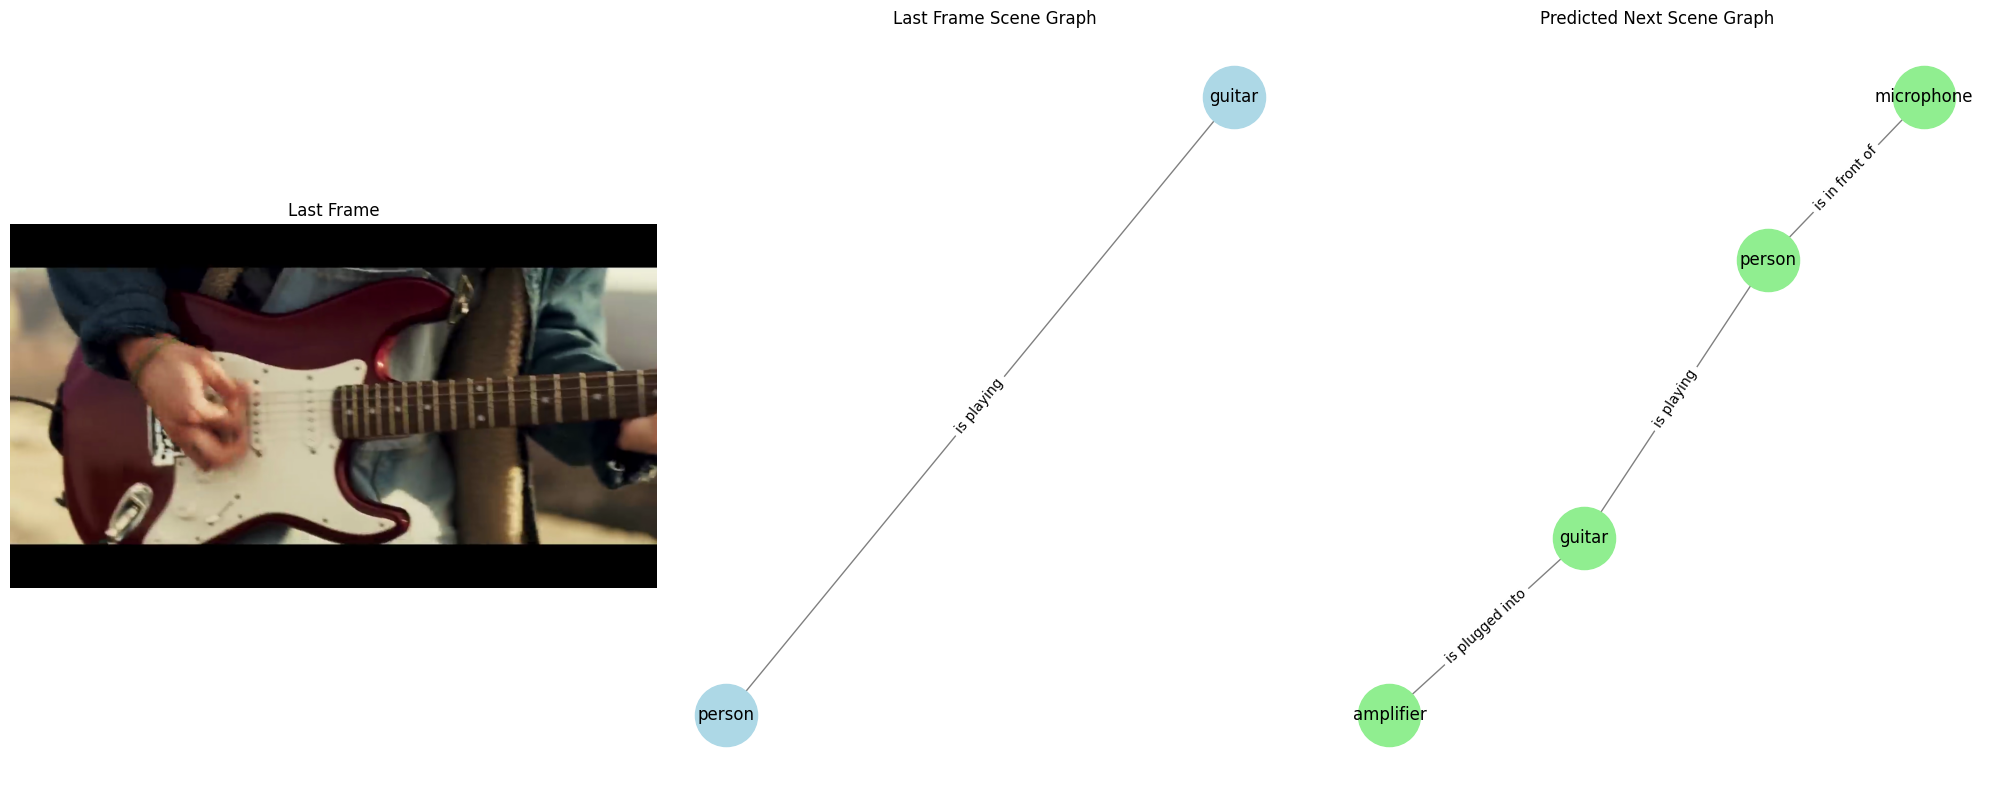

2025-01-30 14:29:30 - INFO - Visualization completed successfully
2025-01-30 14:29:30 - INFO - Visualization and analysis completed successfully



Video Processing Statistics:
Processed frames: 10
Generated scene graphs: 10

Last Frame vs Predicted Scene Comparison:
Last frame objects: 2
Predicted objects: 4

SCENE GRAPH ANALYSIS

LAST FRAME:
--------------------
Objects and their attributes:
- person: playing guitar, wearing denim jacket, wearing bracelet
- guitar: red, electric, strat-style

Relationships:
- person is playing guitar

PREDICTED NEXT FRAME:
--------------------
Objects and their attributes:
- person: playing guitar, wearing denim jacket, wearing bracelet, standing
- guitar: red, electric, strat-style
- microphone: black, standing
- amplifier: black

Relationships:
- person is playing guitar
- microphone is in front of person
- guitar is plugged into amplifier

PREDICTION DESCRIPTION:
--------------------
New objects appearing: microphone, amplifier

Predicted changes:
- person changes: standing

STATISTICS:
--------------------
Total frames processed: 10
Last frame objects: 2
Predicted frame objects: 4
Last fram

In [20]:
import cv2
import numpy as np
from tqdm import tqdm
import tempfile

def process_video_frames(video_path, num_frames=100, duration=5):
    """
    Extract frames from video and generate scene graphs
    
    Args:
        video_path (str): Path to video file
        num_frames (int): Number of frames to extract
        duration (int): Duration of video in seconds to process
    """
    logger.info(f"Starting video processing: {video_path}")
    
    try:
        # Open video
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            logger.error("Failed to open video file")
            raise ValueError("Could not open video file")
        
        # Get video properties
        fps = cap.get(cv2.CAP_PROP_FPS)
        total_frames = int(fps * duration)
        frame_interval = total_frames // num_frames
        
        logger.info(f"Video FPS: {fps}, Total frames to process: {total_frames}")
        logger.info(f"Processing {num_frames} frames with interval {frame_interval}")
        
        # Storage for frames and scene graphs
        frames = []
        scene_graphs = []
        
        # Process frames
        with tqdm(total=num_frames) as pbar:
            frame_count = 0
            while frame_count < total_frames:
                ret, frame = cap.read()
                if not ret:
                    break
                
                if frame_count % frame_interval == 0:
                    # Convert frame to PIL Image
                    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    pil_image = Image.fromarray(frame_rgb)
                    
                    # Generate scene graph
                    logger.debug(f"Generating scene graph for frame {frame_count}")
                    graph, scene_data = generate_scene_graph(pil_image)
                    
                    frames.append(pil_image)
                    scene_graphs.append(scene_data)
                    pbar.update(1)
                    
                    logger.debug(f"Processed frame {frame_count} with {len(scene_data['objects'])} objects")
                
                frame_count += 1
                
                if len(frames) >= num_frames:
                    break
        
        cap.release()
        logger.info(f"Completed processing {len(frames)} frames")
        return frames, scene_graphs
        
    except Exception as e:
        logger.error(f"Video processing failed: {str(e)}")
        logger.debug(f"Traceback: {traceback.format_exc()}")
        raise

def predict_next_scene_graph(previous_scene_graphs, model):
    """
    Predict next scene graph based on previous scene graphs
    
    Args:
        previous_scene_graphs (list): List of previous scene graph data
        model: Initialized Gemini model
    """
    logger.info("Starting scene graph prediction")
    
    try:
        # Create context from previous scene graphs
        context = json.dumps(previous_scene_graphs[-5:], indent=2)  # Use last 5 scene graphs
        
        prompt = f"""Given the sequence of scene graphs below, predict the next scene graph that would logically follow.
        Consider object movements, relationships, and attribute changes.
        Return ONLY a JSON object with the same structure as the input scene graphs.
        
        Previous scene graphs:
        {context}
        
        Predict the next scene graph that would follow this sequence.
        """
        
        logger.debug("Sending prediction request to Gemini API")
        response = model.generate_content(prompt)
        
        # Clean and parse response
        json_text = response.text
        if '```json' in json_text:
            json_text = json_text.split('```json')[1].split('```')[0].strip()
            
        predicted_scene = json.loads(json_text)
        logger.info(f"Generated prediction with {len(predicted_scene['objects'])} objects")
        
        return predicted_scene
        
    except Exception as e:
        logger.error(f"Scene graph prediction failed: {str(e)}")
        logger.debug(f"Traceback: {traceback.format_exc()}")
        raise

def visualize_video_scene_graphs(video_path, num_frames=100, duration=5):
    """
    Process video and visualize scene graphs with prediction
    """
    logger.info("Starting video scene graph visualization")
    
    try:
        # Process video frames
        frames, scene_graphs = process_video_frames(video_path, num_frames, duration)
        
        # Initialize Gemini model for prediction
        model = genai.GenerativeModel('gemini-1.5-pro')
        
        # Predict next scene
        predicted_scene = predict_next_scene_graph(scene_graphs, model)
        
        # Visualize last frame and prediction
        plt.figure(figsize=(20, 8))
        
        # Show last frame
        plt.subplot(1, 3, 1)
        plt.imshow(frames[-1])
        plt.title("Last Frame")
        plt.axis('off')
        
        # Show last scene graph
        plt.subplot(1, 3, 2)
        last_graph = nx.DiGraph()
        for obj in scene_graphs[-1]["objects"]:
            last_graph.add_node(obj["object"], attributes=obj.get("attributes", []))
        for rel in scene_graphs[-1]["relationships"]:
            last_graph.add_edge(rel["subject"], rel["object"], label=rel["predicate"])
            
        pos = nx.spring_layout(last_graph)
        nx.draw_networkx_nodes(last_graph, pos, node_color='lightblue', node_size=2000)
        nx.draw_networkx_edges(last_graph, pos, edge_color='gray', arrows=True)
        nx.draw_networkx_labels(last_graph, pos)
        edge_labels = nx.get_edge_attributes(last_graph, 'label')
        nx.draw_networkx_edge_labels(last_graph, pos, edge_labels=edge_labels)
        plt.title("Last Frame Scene Graph")
        plt.axis('off')
        
        # Show predicted scene graph
        plt.subplot(1, 3, 3)
        pred_graph = nx.DiGraph()
        for obj in predicted_scene["objects"]:
            pred_graph.add_node(obj["object"], attributes=obj.get("attributes", []))
        for rel in predicted_scene["relationships"]:
            pred_graph.add_edge(rel["subject"], rel["object"], label=rel["predicate"])
            
        pos = nx.spring_layout(pred_graph)
        nx.draw_networkx_nodes(pred_graph, pos, node_color='lightgreen', node_size=2000)
        nx.draw_networkx_edges(pred_graph, pos, edge_color='gray', arrows=True)
        nx.draw_networkx_labels(pred_graph, pos)
        edge_labels = nx.get_edge_attributes(pred_graph, 'label')
        nx.draw_networkx_edge_labels(pred_graph, pos, edge_labels=edge_labels)
        plt.title("Predicted Next Scene Graph")
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Print statistics
        print("\nVideo Processing Statistics:")
        print(f"Processed frames: {len(frames)}")
        print(f"Generated scene graphs: {len(scene_graphs)}")
        
        print("\nLast Frame vs Predicted Scene Comparison:")
        print(f"Last frame objects: {len(scene_graphs[-1]['objects'])}")
        print(f"Predicted objects: {len(predicted_scene['objects'])}")
        
        logger.info("Visualization completed successfully")

        print("\n" + "="*50)
        print("SCENE GRAPH ANALYSIS")
        print("="*50)
        
        print("\nLAST FRAME:")
        print("-"*20)
        print("Objects and their attributes:")
        for obj in scene_graphs[-1]["objects"]:
            attrs = ", ".join(obj["attributes"])
            print(f"- {obj['object']}: {attrs}")
        
        print("\nRelationships:")
        for rel in scene_graphs[-1]["relationships"]:
            print(f"- {rel['subject']} {rel['predicate']} {rel['object']}")
            
        print("\nPREDICTED NEXT FRAME:")
        print("-"*20)
        print("Objects and their attributes:")
        for obj in predicted_scene["objects"]:
            attrs = ", ".join(obj["attributes"])
            print(f"- {obj['object']}: {attrs}")
        
        print("\nRelationships:")
        for rel in predicted_scene["relationships"]:
            print(f"- {rel['subject']} {rel['predicate']} {rel['object']}")
        
        # Generate natural language description of the prediction
        print("\nPREDICTION DESCRIPTION:")
        print("-"*20)
        
        # Compare objects and relationships
        new_objects = set(obj["object"] for obj in predicted_scene["objects"]) - \
                     set(obj["object"] for obj in scene_graphs[-1]["objects"])
        removed_objects = set(obj["object"] for obj in scene_graphs[-1]["objects"]) - \
                         set(obj["object"] for obj in predicted_scene["objects"])
        
        # Generate description
        description = []
        if new_objects:
            description.append(f"New objects appearing: {', '.join(new_objects)}")
        if removed_objects:
            description.append(f"Objects no longer in scene: {', '.join(removed_objects)}")
            
        # Analyze movement and changes
        description.append("\nPredicted changes:")
        for obj in predicted_scene["objects"]:
            # Find corresponding object in last frame
            last_obj = next((o for o in scene_graphs[-1]["objects"] 
                           if o["object"] == obj["object"]), None)
            if last_obj:
                # Compare attributes
                new_attrs = set(obj["attributes"]) - set(last_obj["attributes"])
                if new_attrs:
                    description.append(f"- {obj['object']} changes: {', '.join(new_attrs)}")
        
        print("\n".join(description))
        
        print("\nSTATISTICS:")
        print("-"*20)
        print(f"Total frames processed: {len(frames)}")
        print(f"Last frame objects: {len(scene_graphs[-1]['objects'])}")
        print(f"Predicted frame objects: {len(predicted_scene['objects'])}")
        print(f"Last frame relationships: {len(scene_graphs[-1]['relationships'])}")
        print(f"Predicted relationships: {len(predicted_scene['relationships'])}")
        
        logger.info("Visualization and analysis completed successfully")
        
    except Exception as e:
        logger.error(f"Visualization failed: {str(e)}")
        logger.debug(f"Traceback: {traceback.format_exc()}")
        raise

# Example usage
visualize_video_scene_graphs("./data/videoSong.mp4", num_frames=10, duration=90)


2025-02-02 11:47:51 - INFO - Starting scene graph prediction pipeline
2025-02-02 11:47:51 - INFO - Starting environment setup...
2025-02-02 11:47:51 - INFO - Environment setup completed
2025-02-02 11:47:51 - INFO - Loading annotation files...
2025-02-02 11:48:00 - INFO - Loaded annotations with 36 objects, 26 relationships
2025-02-02 11:48:00 - INFO - Processing video: BPT87.mp4
2025-02-02 11:48:00 - INFO - Found 40 frames for video BPT87.mp4
Extracting scene graphs:   0%|          | 0/40 [00:00<?, ?it/s]2025-02-02 11:48:00 - DEBUG - Extracted scene graph with 1 objects and 3 relationships
2025-02-02 11:48:00 - DEBUG - Found scene graph for frame BPT87.mp4/000205.png
2025-02-02 11:48:00 - DEBUG - Extracted scene graph with 1 objects and 3 relationships
2025-02-02 11:48:00 - DEBUG - Found scene graph for frame BPT87.mp4/000216.png
2025-02-02 11:48:00 - DEBUG - Extracted scene graph with 1 objects and 3 relationships
2025-02-02 11:48:00 - DEBUG - Found scene graph for frame BPT87.mp4/000

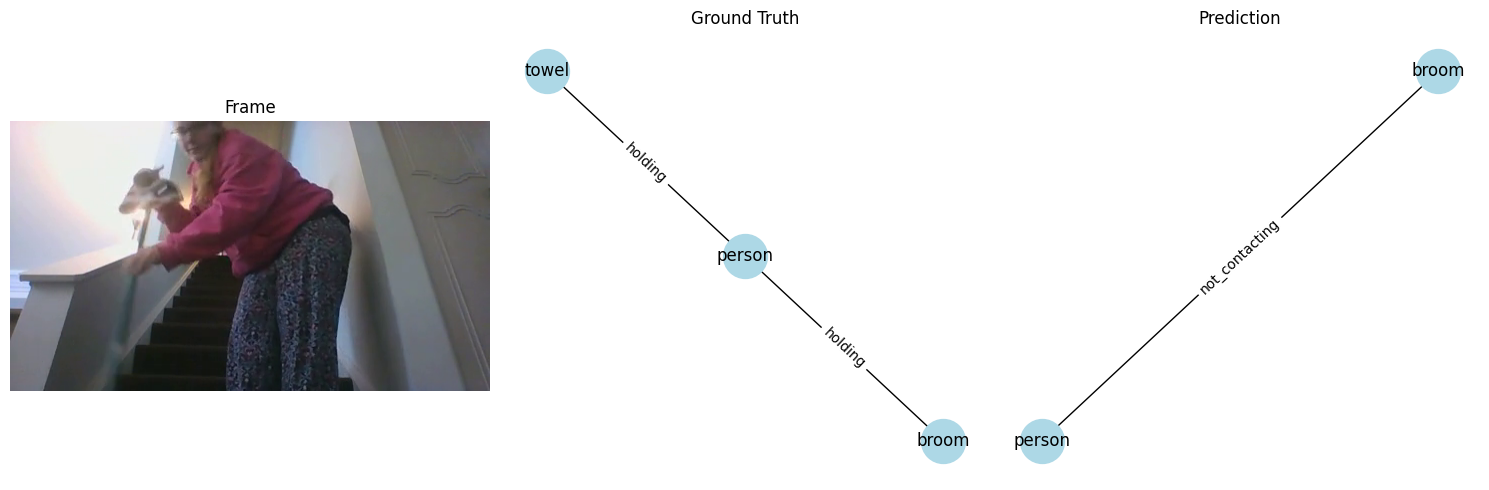

2025-02-02 11:48:20 - DEBUG - Visualizing comparison for frame BPT87.mp4/000411.png
2025-02-02 11:48:20 - DEBUG - Ground truth structure: dict_keys(['objects', 'relationships'])
2025-02-02 11:48:20 - DEBUG - Prediction structure: dict_keys(['objects', 'relationships'])
2025-02-02 11:48:20 - DEBUG - STREAM b'IHDR' 16 13
2025-02-02 11:48:20 - DEBUG - STREAM b'pHYs' 41 9
2025-02-02 11:48:20 - DEBUG - STREAM b'IDAT' 62 4096


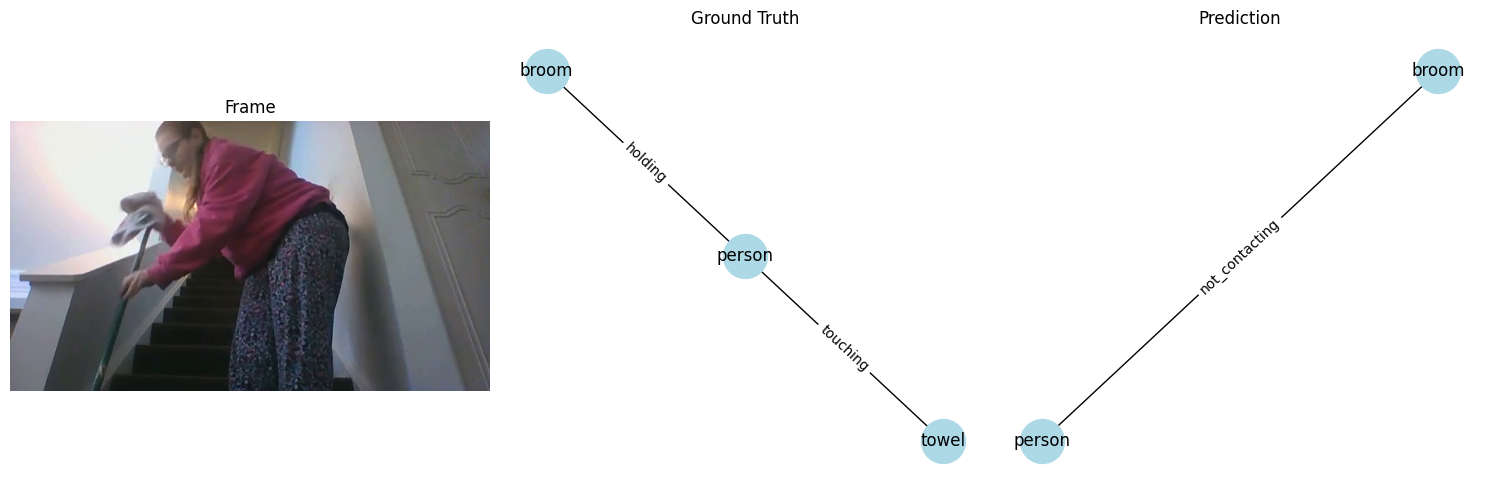

2025-02-02 11:48:20 - DEBUG - Visualizing comparison for frame BPT87.mp4/000412.png
2025-02-02 11:48:20 - DEBUG - Ground truth structure: dict_keys(['objects', 'relationships'])
2025-02-02 11:48:20 - DEBUG - Prediction structure: dict_keys(['objects', 'relationships'])
2025-02-02 11:48:20 - DEBUG - STREAM b'IHDR' 16 13
2025-02-02 11:48:20 - DEBUG - STREAM b'pHYs' 41 9
2025-02-02 11:48:20 - DEBUG - STREAM b'IDAT' 62 4096


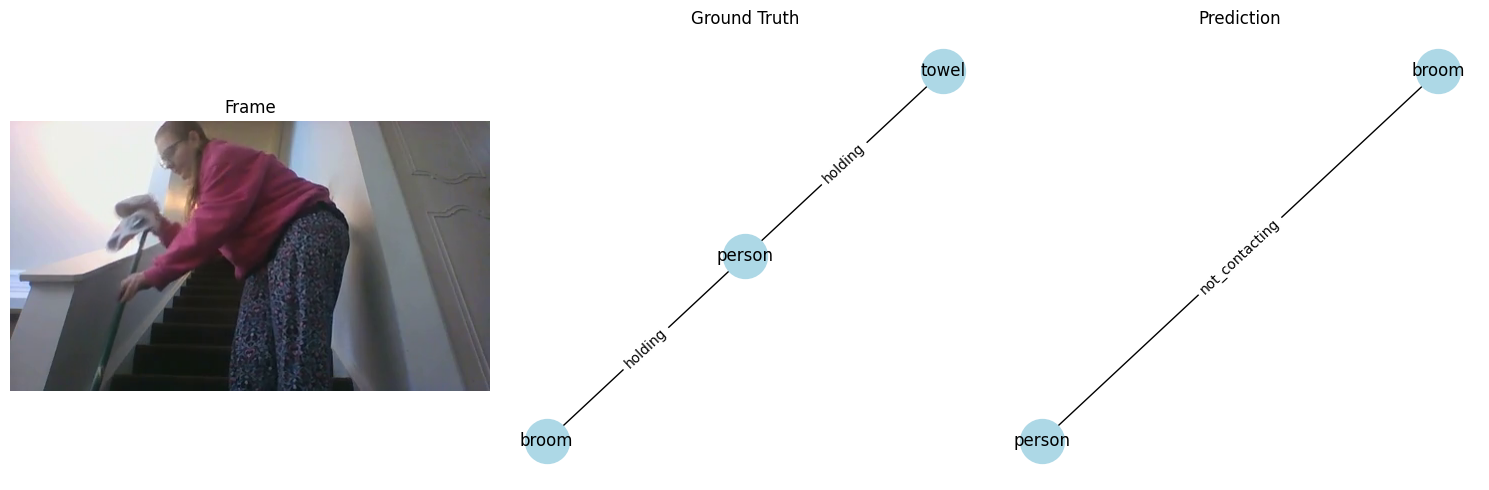

2025-02-02 11:48:20 - DEBUG - Visualizing comparison for frame BPT87.mp4/000421.png
2025-02-02 11:48:20 - DEBUG - Ground truth structure: dict_keys(['objects', 'relationships'])
2025-02-02 11:48:20 - DEBUG - Prediction structure: dict_keys(['objects', 'relationships'])
2025-02-02 11:48:20 - DEBUG - STREAM b'IHDR' 16 13
2025-02-02 11:48:20 - DEBUG - STREAM b'pHYs' 41 9
2025-02-02 11:48:20 - DEBUG - STREAM b'IDAT' 62 4096


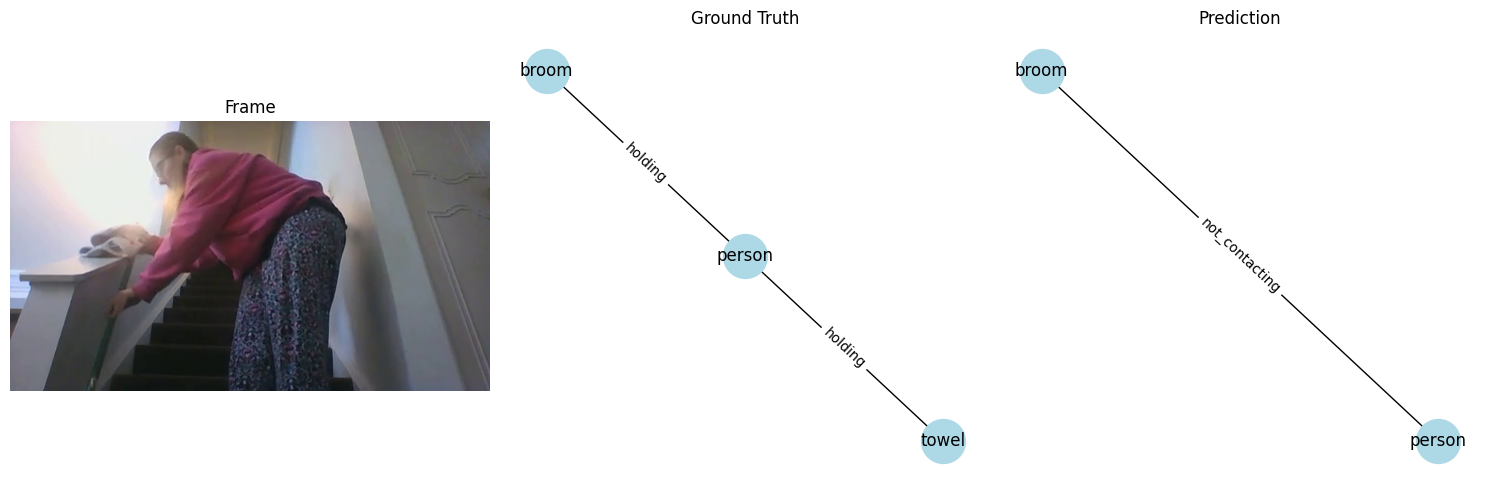

2025-02-02 11:48:20 - DEBUG - Visualizing comparison for frame BPT87.mp4/000438.png
2025-02-02 11:48:20 - DEBUG - Ground truth structure: dict_keys(['objects', 'relationships'])
2025-02-02 11:48:20 - DEBUG - Prediction structure: dict_keys(['objects', 'relationships'])
2025-02-02 11:48:20 - DEBUG - STREAM b'IHDR' 16 13
2025-02-02 11:48:20 - DEBUG - STREAM b'pHYs' 41 9
2025-02-02 11:48:20 - DEBUG - STREAM b'IDAT' 62 4096


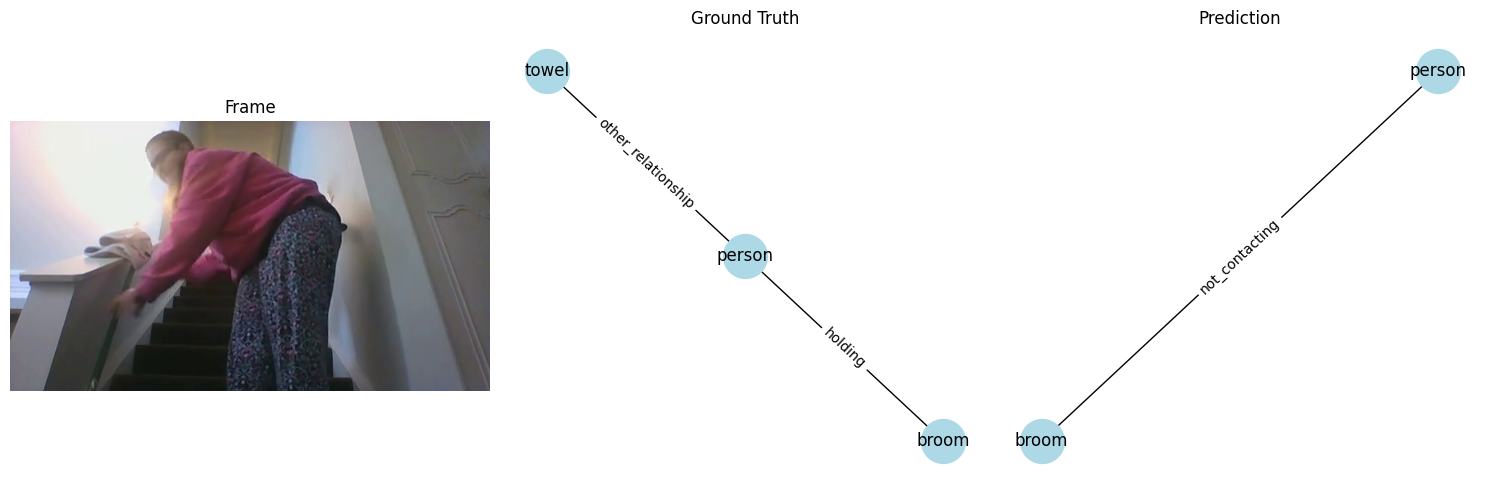

2025-02-02 11:48:20 - DEBUG - Visualizing comparison for frame BPT87.mp4/000441.png
2025-02-02 11:48:20 - DEBUG - Ground truth structure: dict_keys(['objects', 'relationships'])
2025-02-02 11:48:20 - DEBUG - Prediction structure: dict_keys(['objects', 'relationships'])
2025-02-02 11:48:20 - DEBUG - STREAM b'IHDR' 16 13
2025-02-02 11:48:20 - DEBUG - STREAM b'pHYs' 41 9
2025-02-02 11:48:20 - DEBUG - STREAM b'IDAT' 62 4096


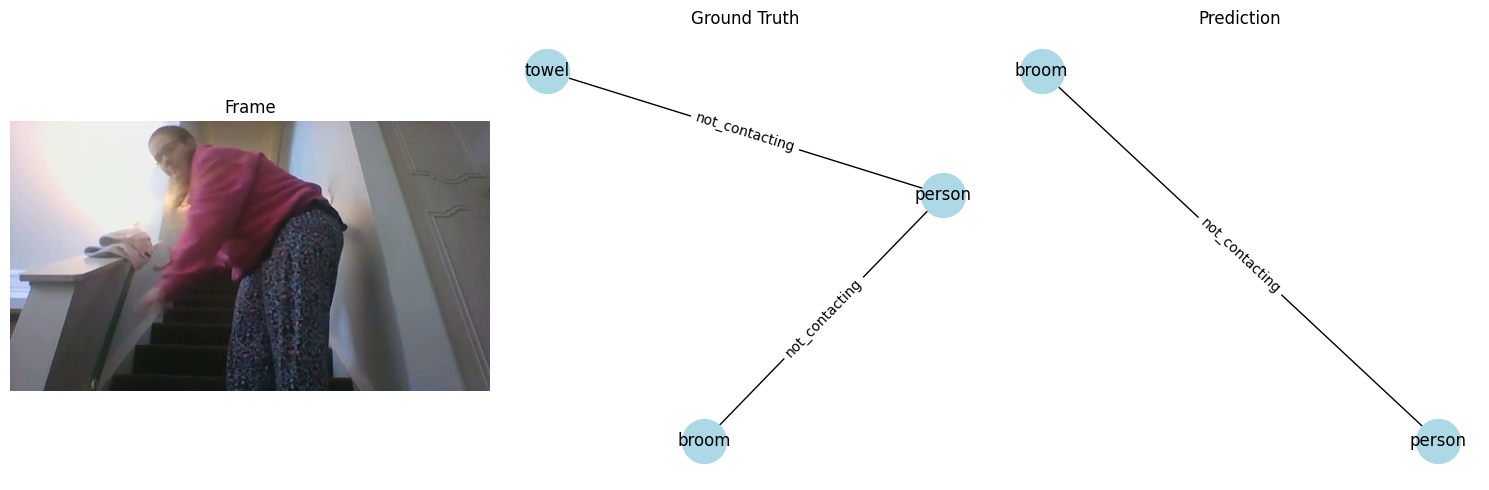

2025-02-02 11:48:20 - DEBUG - Visualizing comparison for frame BPT87.mp4/000443.png
2025-02-02 11:48:20 - DEBUG - Ground truth structure: dict_keys(['objects', 'relationships'])
2025-02-02 11:48:20 - DEBUG - Prediction structure: dict_keys(['objects', 'relationships'])
2025-02-02 11:48:20 - DEBUG - STREAM b'IHDR' 16 13
2025-02-02 11:48:20 - DEBUG - STREAM b'pHYs' 41 9
2025-02-02 11:48:20 - DEBUG - STREAM b'IDAT' 62 4096


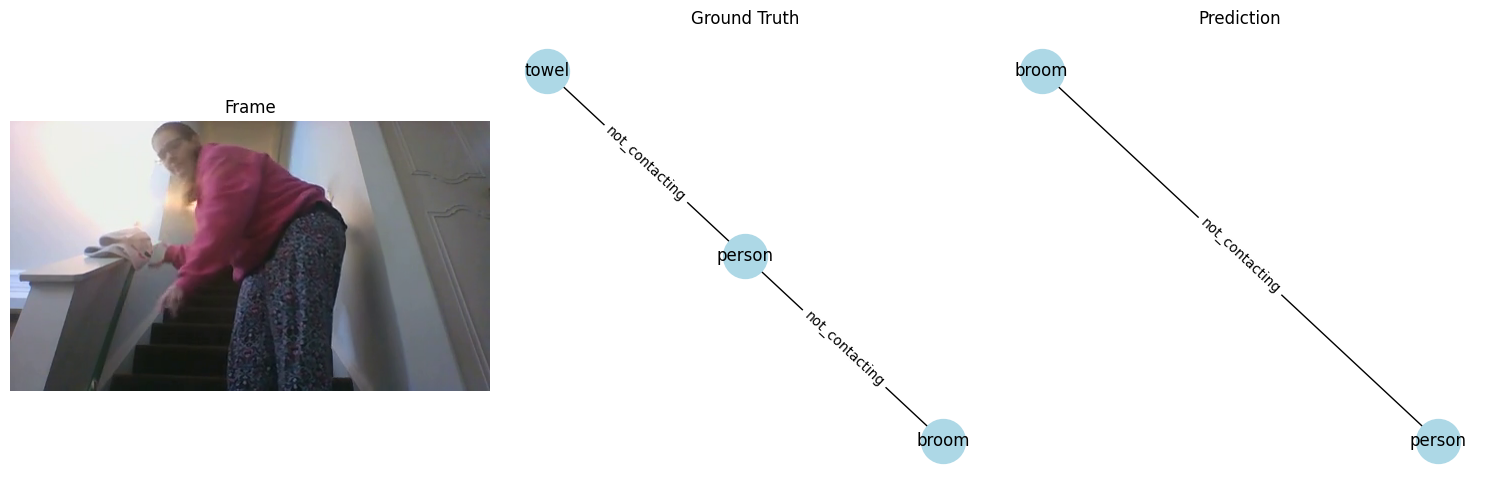

2025-02-02 11:48:20 - DEBUG - Visualizing comparison for frame BPT87.mp4/000465.png
2025-02-02 11:48:20 - DEBUG - Ground truth structure: dict_keys(['objects', 'relationships'])
2025-02-02 11:48:20 - DEBUG - Prediction structure: dict_keys(['objects', 'relationships'])
2025-02-02 11:48:20 - DEBUG - STREAM b'IHDR' 16 13
2025-02-02 11:48:20 - DEBUG - STREAM b'pHYs' 41 9
2025-02-02 11:48:20 - DEBUG - STREAM b'IDAT' 62 4096


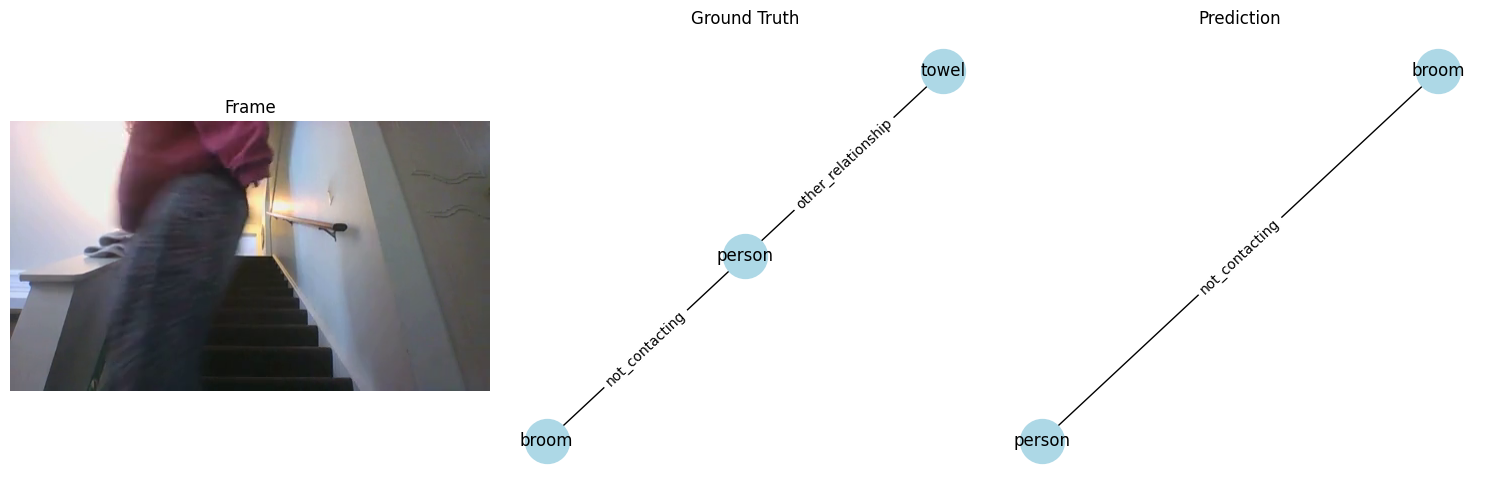

2025-02-02 11:48:20 - INFO - Pipeline completed successfully


In [10]:
# Import required libraries
import os
import google.generativeai as genai
import dotenv
import json
import logging
import traceback
import pickle
from glob import glob
from tqdm import tqdm
import networkx as nx
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import base64

# Configure logging
logging.basicConfig(
    level=logging.DEBUG,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)
logger = logging.getLogger(__name__)

def setup_environment():
    """Setup environment and API configurations"""
    try:
        logger.info("Starting environment setup...")
        dotenv.load_dotenv()
        api_key = os.getenv("GEMINI_API_KEY")
        if not api_key:
            raise ValueError("Missing GEMINI_API_KEY")
        genai.configure(api_key=api_key)
        model = genai.GenerativeModel('gemini-1.5-flash')
        logger.info("Environment setup completed")
        return model
    except Exception as e:
        logger.error(f"Environment setup failed: {str(e)}")
        raise

def load_annotations():
    """Load annotation files and object/relationship classes"""
    logger.info("Loading annotation files...")
    try:
        # Load object bbox and relationship data
        with open('data/object_bbox_and_relationship.pkl', 'rb') as f:
            bbox_rel_data = pickle.load(f)
        
        # Load object classes
        with open('data/object_classes.txt', 'r') as f:
            object_classes = f.read().splitlines()
            
        # Load relationship classes
        with open('data/relationship_classes.txt', 'r') as f:
            relationship_classes = f.read().splitlines()
            
        logger.info(f"Loaded annotations with {len(object_classes)} objects, {len(relationship_classes)} relationships")
        return bbox_rel_data, object_classes, relationship_classes
    
    except Exception as e:
        logger.error(f"Failed to load annotations: {str(e)}")
        raise

def process_video_frames(video_id, bbox_rel_data):
    """Process frames from a specific video folder"""
    try:
        logger.info(f"Processing video: {video_id}")
        
        # Get all frames for this video
        frame_path = f"./data/frames/{video_id}/*.png"
        frame_files = sorted(glob(frame_path))
        
        if not frame_files:
            logger.error(f"No frames found in {frame_path}")
            return None
            
        logger.info(f"Found {len(frame_files)} frames for video {video_id}")
        
        # Extract scene graphs
        scene_graphs = []
        for frame_file in tqdm(frame_files, desc="Extracting scene graphs"):
            # Construct the frame ID as it appears in the pkl file
            frame_name = os.path.basename(frame_file)
            frame_id = f"{video_id}/{frame_name}"
            
            # Get scene graph from annotations
            scene_graph = extract_scene_graph(frame_id, bbox_rel_data)
            
            if scene_graph:
                logger.debug(f"Found scene graph for frame {frame_id}")
                scene_graphs.append({
                    'frame_id': frame_id,
                    'scene_graph': scene_graph
                })
            else:
                logger.warning(f"No scene graph found for frame {frame_id}")
        
        logger.info(f"Extracted {len(scene_graphs)} scene graphs")
        return scene_graphs
    
    except Exception as e:
        logger.error(f"Video processing failed: {str(e)}")
        logger.debug(f"Traceback: {traceback.format_exc()}")
        raise

def extract_scene_graph(frame_id, bbox_rel_data):
    """Extract scene graph from annotations"""
    try:
        # Get annotations for this frame
        frame_anns = bbox_rel_data.get(frame_id, [])
        if not frame_anns:
            logger.debug(f"No annotations found for frame {frame_id}")
            return None
            
        scene_graph = {
            "objects": [],
            "relationships": []
        }
        
        added_objects = set()
        
        for ann in frame_anns:
            if not ann.get('visible', True):
                continue
                
            obj_class = ann['class']
            if obj_class not in added_objects:
                scene_graph["objects"].append({
                    "object": obj_class,
                    "attributes": [],
                    "bbox": ann.get('bbox', [])
                })
                added_objects.add(obj_class)
            
            # Add relationships
            for rel_type in ['attention_relationship', 'spatial_relationship', 'contacting_relationship']:
                for rel in ann.get(rel_type, []):
                    scene_graph["relationships"].append({
                        "subject": "person",
                        "predicate": rel,
                        "object": obj_class
                    })
        
        if scene_graph["objects"]:
            logger.debug(f"Extracted scene graph with {len(scene_graph['objects'])} objects and {len(scene_graph['relationships'])} relationships")
            return scene_graph
        else:
            logger.debug(f"No valid objects found in annotations for frame {frame_id}")
            return None
    
    except Exception as e:
        logger.error(f"Failed to extract scene graph for frame {frame_id}: {str(e)}")
        return None

def print_scene_graph(scene_graph):
    """Pretty print scene graph"""
    if not scene_graph:
        print("No scene graph available")
        return
        
    print("\nObjects:")
    for obj in scene_graph["objects"]:
        attrs = ", ".join(obj.get("attributes", []))
        bbox = obj.get("bbox", [])
        print(f"- {obj['object']}" + 
              (f" ({attrs})" if attrs else "") +
              (f" bbox: {bbox}" if bbox else ""))
    
    print("\nRelationships:")
    for rel in scene_graph["relationships"]:
        print(f"- {rel['subject']} {rel['predicate']} {rel['object']}")

def split_scene_graphs(scene_graphs, split_ratio=0.8):
    """Split scene graphs into training and testing sets chronologically"""
    try:
        # Sort by frame number to ensure chronological order
        scene_graphs.sort(key=lambda x: int(x['frame_id'].split('/')[-1].split('.')[0]))
        
        split_idx = int(len(scene_graphs) * split_ratio)
        train_graphs = scene_graphs[:split_idx]
        test_graphs = scene_graphs[split_idx:]
        
        logger.info(f"Split {len(scene_graphs)} graphs chronologically into {len(train_graphs)} train and {len(test_graphs)} test")
        logger.debug(f"Training frames: {train_graphs[0]['frame_id']} to {train_graphs[-1]['frame_id']}")
        logger.debug(f"Testing frames: {test_graphs[0]['frame_id']} to {test_graphs[-1]['frame_id']}")
        
        return train_graphs, test_graphs
    except Exception as e:
        logger.error(f"Failed to split scene graphs: {str(e)}")
        raise

def parse_model_response(response_text):
    """Parse model response to extract JSON"""
    try:
        # Remove markdown formatting if present
        if '```json' in response_text:
            json_text = response_text.split('```json')[1].split('```')[0].strip()
        elif '```' in response_text:
            json_text = response_text.split('```')[1].strip()
        else:
            json_text = response_text.strip()
            
        # Parse JSON
        scene_graph = json.loads(json_text)
        logger.debug(f"Successfully parsed response into scene graph with {len(scene_graph.get('objects', []))} objects")
        return scene_graph
    
    except Exception as e:
        logger.error(f"Failed to parse model response: {str(e)}")
        logger.debug(f"Response text: {response_text}")
        return None

def predict_scene_graphs(train_graphs, num_predictions, model, vocabulary_type='closed', 
                        object_classes=None, relationship_classes=None):
    """Generate scene graph predictions using frame images and scene graphs as context"""
    try:
        logger.info(f"Generating {num_predictions} sequential predictions using {vocabulary_type} vocabulary")
        predictions = []
        context_graphs = train_graphs.copy()
        
        # Debug initial context
        logger.debug("\n=======INITIAL CONTEXT========")
        logger.debug(f"Starting with {len(context_graphs)} training frames")
        logger.debug(f"Frame numbers: {[int(g['frame_id'].split('/')[-1].split('.')[0]) for g in context_graphs]}")
        logger.debug("============================\n")
        
        # Get test frame IDs to predict
        test_frame_nums = []
        last_train_num = int(context_graphs[-1]['frame_id'].split('/')[-1].split('.')[0])
        
        # Find existing frame files after the last training frame
        video_id = context_graphs[0]['frame_id'].split('/')[0]
        frame_pattern = f"./data/frames/{video_id}/*.png"
        all_frames = sorted(glob(frame_pattern))
        
        for frame_path in all_frames:
            frame_num = int(frame_path.split('/')[-1].split('.')[0])
            if frame_num > last_train_num:
                test_frame_nums.append(frame_num)
        
        logger.info(f"Found {len(test_frame_nums)} test frames to predict after frame {last_train_num}")
        
        # Prepare vocabulary context
        vocab_context = ""
        if vocabulary_type == 'closed':
            vocab_context = f"Available objects: {', '.join(object_classes)}\nAvailable relationships: {', '.join(relationship_classes)}"
        
        for i, next_frame_num in enumerate(test_frame_nums[:num_predictions], 1):
            logger.debug(f"\n=======PREDICTION {i}/{num_predictions}========")
            logger.debug(f"Predicting frame {next_frame_num:06d}")
            logger.debug(f"Context has {len(context_graphs)} frames")
            logger.debug(f"Last 3 context frames: {[int(g['frame_id'].split('/')[-1].split('.')[0]) for g in context_graphs[-3:]]}")
            
            # Load previous frame images as base64
            frame_contexts = []
            for ctx in context_graphs:
                frame_path = f"./data/frames/{ctx['frame_id']}"
                try:
                    with open(frame_path, 'rb') as img_file:
                        img_data = base64.b64encode(img_file.read()).decode()
                        frame_num = int(ctx['frame_id'].split('/')[-1].split('.')[0])
                        frame_contexts.append({
                            'frame_num': frame_num,
                            'image': img_data,
                            'scene_graph': ctx['scene_graph']
                        })
                except Exception as e:
                    logger.warning(f"Failed to load frame image {frame_path}: {e}")
            
            # Debug context information
            debug_context = "\n=======CONTEXT DETAILS========\n"
            for ctx in frame_contexts[-3:]:  # Show last 3 frames for brevity
                frame_num = ctx['frame_num']
                scene_graph = ctx['scene_graph']
                debug_context += f"\nFrame {frame_num:06d}:\n"
                debug_context += "Objects:\n"
                for obj in scene_graph['objects']:
                    debug_context += f"  - {obj['object']}\n"
                debug_context += "Relationships:\n"
                for rel in scene_graph['relationships']:
                    debug_context += f"  - {rel['subject']} {rel['predicate']} {rel['object']}\n"
            debug_context += "\n========================\n"
            
            logger.debug(debug_context)
            
            # Prepare context string with both images and scene graphs
            context_str = json.dumps([{
                'frame_num': ctx['frame_num'],
                'scene_graph': ctx['scene_graph']
            } for ctx in frame_contexts], indent=2)
            
            prompt = f"""Given the sequence of scene graphs below, predict the next scene graph for frame {next_frame_num:06d}.
            Consider the logical progression of objects, their interactions, and relationships.
            
            {vocab_context if vocabulary_type == 'closed' else ''}

            Previous frames (with scene graphs):
            {context_str}
            
            Predict the next scene graph that maintains temporal consistency with the sequence above.
            Return ONLY a JSON object with this structure:
            {{
                "objects": [
                    {{"object": "<object_name>", "attributes": []}},
                ],
                "relationships": [
                    {{"subject": "<object1>", "predicate": "<relationship>", "object": "<object2>"}}
                ]
            }}
            Do not include any other text or formatting, just the JSON object.
            """
            
            # Debug prompt
            logger.debug("\n=======PROMPT========\n")
            logger.debug(prompt)
            logger.debug("\n===================\n")
            
            response = model.generate_content(prompt)
            predicted_graph = parse_model_response(response.text)
            
            if predicted_graph:
                # Debug prediction and context update
                logger.debug("\n=======CONTEXT UPDATE========")
                logger.debug(f"Adding prediction for frame {next_frame_num:06d} to context")
                logger.debug("Predicted scene graph:")
                logger.debug("Objects:")
                for obj in predicted_graph['objects']:
                    logger.debug(f"  - {obj['object']}")
                logger.debug("Relationships:")
                for rel in predicted_graph['relationships']:
                    logger.debug(f"  - {rel['subject']} {rel['predicate']} {rel['object']}")
                
                # Create prediction entry with proper frame ID format
                prediction_entry = {
                    'frame_id': f"{video_id}/{next_frame_num:06d}.png",
                    'scene_graph': predicted_graph
                }
                
                predictions.append(prediction_entry)
                context_graphs.append(prediction_entry)
                
                logger.debug(f"Context size now: {len(context_graphs)} frames")
                logger.debug(f"Context frame numbers: {[int(g['frame_id'].split('/')[-1].split('.')[0]) for g in context_graphs[-3:]]}")
                logger.debug("============================\n")
            else:
                logger.warning(f"Failed to predict frame {next_frame_num:06d}")
                continue
                
        return predictions
        
    except Exception as e:
        logger.error(f"Prediction failed: {str(e)}")
        raise

def visualize_scene_graph(scene_graph, title, ax):
    """Visualize scene graph using networkx"""
    try:
        if not scene_graph or 'objects' not in scene_graph:
            logger.error(f"Invalid scene graph structure for {title}: {scene_graph}")
            return
            
        G = nx.Graph()
        
        # Add object nodes
        for obj in scene_graph["objects"]:
            if isinstance(obj, dict) and "object" in obj:
                G.add_node(obj["object"], type="object")
            else:
                logger.warning(f"Invalid object structure: {obj}")
                continue
            
        # Add relationship edges
        for rel in scene_graph.get("relationships", []):
            if isinstance(rel, dict) and all(k in rel for k in ["subject", "predicate", "object"]):
                G.add_edge(rel["subject"], rel["object"], 
                          label=rel["predicate"])
            else:
                logger.warning(f"Invalid relationship structure: {rel}")
                continue
            
        # Draw graph
        if G.number_of_nodes() > 0:
            pos = nx.spring_layout(G)
            nx.draw_networkx_nodes(G, pos, node_color='lightblue', 
                                 node_size=1000, ax=ax)
            nx.draw_networkx_labels(G, pos, ax=ax)
            nx.draw_networkx_edges(G, pos, ax=ax)
            edge_labels = nx.get_edge_attributes(G, 'label')
            nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, ax=ax)
        else:
            logger.warning(f"No valid nodes to visualize for {title}")
            
        ax.set_title(title)
        ax.axis('off')
        
    except Exception as e:
        logger.error(f"Failed to visualize scene graph: {str(e)}")
        logger.debug(f"Scene graph: {scene_graph}")
        raise

def visualize_comparison(frame_path, ground_truth, prediction):
    """Visualize frame image with ground truth and predicted graphs"""
    try:
        fig = plt.figure(figsize=(15, 5))
        
        # Show frame image
        ax1 = fig.add_subplot(131)
        img = Image.open(frame_path)
        ax1.imshow(img)
        ax1.set_title("Frame")
        ax1.axis('off')
        
        # Show ground truth graph
        ax2 = fig.add_subplot(132)
        visualize_scene_graph(ground_truth, "Ground Truth", ax2)
        
        # Show predicted graph
        ax3 = fig.add_subplot(133)
        visualize_scene_graph(prediction, "Prediction", ax3)
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        logger.error(f"Visualization failed: {str(e)}")
        raise

def visualize_results(test_graphs, predictions):
    """Visualize all results"""
    try:
        if not predictions:
            logger.warning("No predictions to visualize")
            return
            
        logger.info("Visualizing results...")
        for i, (test_graph, pred_graph) in enumerate(zip(test_graphs, predictions)):
            try:
                frame_path = f"./data/frames/{test_graph['frame_id']}"
                logger.debug(f"Visualizing comparison for frame {test_graph['frame_id']}")
                
                # Extract scene graph from prediction (it's nested in the prediction structure)
                pred_scene_graph = pred_graph['scene_graph'] if isinstance(pred_graph, dict) else pred_graph
                
                # Log the structures for debugging
                logger.debug(f"Ground truth structure: {test_graph['scene_graph'].keys()}")
                logger.debug(f"Prediction structure: {pred_scene_graph.keys()}")
                
                visualize_comparison(
                    frame_path,
                    test_graph['scene_graph'],
                    pred_scene_graph
                )
            except Exception as e:
                logger.error(f"Failed to visualize comparison {i+1}: {str(e)}")
                logger.debug(f"Ground truth: {test_graph}")
                logger.debug(f"Prediction: {pred_graph}")
                continue
                
    except Exception as e:
        logger.error(f"Visualization failed: {str(e)}")
        raise

def validate_vocabulary(scene_graph, object_classes, relationship_classes):
    """Validate and normalize scene graph vocabulary against allowed classes"""
    try:
        validated_graph = {
            "objects": [],
            "relationships": []
        }
        
        # Helper function to find closest match in vocabulary
        def find_closest_match(word, vocab):
            # Direct match
            if word.lower() in [v.lower() for v in vocab]:
                return vocab[[v.lower() for v in vocab].index(word.lower())]
            
            # Common substitutions
            substitutions = {
                # Objects
                'person': ['human', 'man', 'woman', 'individual', 'someone'],
                'box': ['container', 'package', 'carton'],
                'door': ['entrance', 'doorway', 'gate'],
                'mirror': ['reflection', 'glass'],
                # Relationships
                'looking_at': ['watching', 'observing', 'viewing', 'gazing_at'],
                'holding': ['carrying', 'gripping', 'grasping'],
                'touching': ['contacting', 'in_contact_with'],
                'in_front_of': ['before', 'facing'],
                'behind': ['at_back_of', 'in_back_of'],
                'not_contacting': ['separate_from', 'away_from', 'not_touching'],
                'not_looking_at': ['looking_away', 'facing_away']
            }
            
            # Check substitutions
            for valid_term, alternatives in substitutions.items():
                if word.lower() in [alt.lower() for alt in alternatives] and valid_term in vocab:
                    return valid_term
            
            # Default fallbacks
            if vocab == relationship_classes:
                logger.warning(f"Unknown relationship '{word}', using 'other_relationship'")
                return 'other_relationship'
            else:
                logger.warning(f"Unknown object '{word}', using 'other_object'")
                return 'other_object'
        
        # Validate objects
        seen_objects = set()
        for obj in scene_graph.get("objects", []):
            if isinstance(obj, dict) and "object" in obj:
                obj_name = obj["object"]
                validated_name = find_closest_match(obj_name, object_classes)
                
                if validated_name not in seen_objects:
                    validated_graph["objects"].append({
                        "object": validated_name,
                        "attributes": obj.get("attributes", []),
                        "bbox": obj.get("bbox", [])
                    })
                    seen_objects.add(validated_name)
        
        # Validate relationships
        for rel in scene_graph.get("relationships", []):
            if isinstance(rel, dict) and all(k in rel for k in ["subject", "predicate", "object"]):
                validated_rel = {
                    "subject": find_closest_match(rel["subject"], object_classes),
                    "predicate": find_closest_match(rel["predicate"], relationship_classes),
                    "object": find_closest_match(rel["object"], object_classes)
                }
                validated_graph["relationships"].append(validated_rel)
        
        logger.debug(f"Validated scene graph: {len(validated_graph['objects'])} objects, {len(validated_graph['relationships'])} relationships")
        return validated_graph
        
    except Exception as e:
        logger.error(f"Vocabulary validation failed: {str(e)}")
        logger.debug(f"Original scene graph: {scene_graph}")
        return scene_graph  # Return original if validation fails

def main():
    """Main execution function"""
    try:
        logger.info("Starting scene graph prediction pipeline")
        
        # Setup
        model = setup_environment()
        
        # Load data
        bbox_rel_data, object_classes, relationship_classes = load_annotations()
        
        # Process specific video
        video_id = "BPT87.mp4"
        scene_graphs = process_video_frames(video_id, bbox_rel_data)
        
        if not scene_graphs:
            logger.warning(f"No scene graphs found for video {video_id}")
            return
            
        # Split into train/test
        train_graphs, test_graphs = split_scene_graphs(scene_graphs)
        
        # Generate predictions
        vocabulary_type = 'closed'  # or 'open'
        predictions = predict_scene_graphs(
            train_graphs,
            len(test_graphs),
            model,
            vocabulary_type,
            object_classes,
            relationship_classes
        )
        
        # Visualize results
        visualize_results(test_graphs, predictions)
        
        logger.info("Pipeline completed successfully")
        
    except Exception as e:
        logger.error(f"Pipeline failed: {str(e)}")
        logger.debug(f"Traceback: {traceback.format_exc()}")
        raise

if __name__ == "__main__":
    main()
